In [3]:
from time import time_ns
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.linalg import lu, solve_triangular
from scipy.sparse.linalg import bicgstab, gmres
import time

In [4]:
L = 10
m = 64
n = m * m
delta = (2 * L) / m

e0 = np.zeros((n, 1))
e1 = np.ones((n, 1))
e2 = np.copy(e1)
e4 = np.copy(e0)

for j in range(1, m + 1):
    e2[m * j - 1] = 0
    e4[m * j - 1] = 1

e3 = np.zeros_like(e2)
e5 = np.zeros_like(e4)

for i in range(1, n):
    e3[i] = e2[i - 1]
    e5[i] = e4[i - 1]
e3[0] = e2[-1]
e5[0] = e4[-1]

diagonals_A = [e1.flatten(), e1.flatten(), e5.flatten(),
               e2.flatten(), -4 * e1.flatten(), e3.flatten(),
               e4.flatten(), e1.flatten(), e1.flatten()]
offsets_A = [-(n - m), -m, -m + 1, -1, 0, 1, m - 1, m, (n - m)]

A = spdiags(diagonals_A, offsets_A, n, n) / (delta**2)
A_sparse = A

diagonals_B = [e1.flatten(), -e1.flatten(), e1.flatten(), -e1.flatten()]
offsets_B = [-(n - m), -m, m, (n - m)]
B = spdiags(diagonals_B, offsets_B, n, n) / (2 * delta)
B_sparse = B

for i in range(1, n):
    e1[i] = e4[i - 1]

diagonals_C = [e1.flatten(), -e2.flatten(), e3.flatten(), -e4.flatten()]
offsets_C = [-m + 1, -1, 1, m - 1]
C = spdiags(diagonals_C, offsets_C, n, n) / (2 * delta)
C_sparse = C

A_dense = A.toarray()
A_dense[0, 0] = 2 / (delta**2)
B_dense = B.toarray()
C_dense = C.toarray()

tspan = np.arange(0, 4.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w0 = np.exp(-X**2 - Y**2 / 20).flatten()

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

def fft_rhs(t, wt2, nx, ny, N, KX, KY, K, nu):
    w = wt2.reshape((nx, ny))
    wt = fft2(w)
    
    psit = -wt / K
    psi = np.real(ifft2(psit)).reshape(N)
    
    rhs = (nu * A_dense.dot(wt2)+ (B_dense.dot(wt2)) * (C_dense.dot(psi))- (B_dense.dot(psi)) * (C_dense.dot(wt2)))
    return rhs

def ab_rhs(t, w, A_dense, B_dense, C_dense, nu):
    psi = np.linalg.solve(A_dense, w)

    rhs = (nu * A_dense.dot(w)+ (B_dense.dot(w)) * (C_dense.dot(psi))- (B_dense.dot(psi)) * (C_dense.dot(w)))
    return rhs

P, L, U = lu(A_dense)

def lu_rhs(t, w, A_dense, B_dense, C_dense, nu, L, U, P):
    Pb = np.dot(P, w)
    y = solve_triangular(L, Pb, lower=True)
    x = solve_triangular(U, y)

    rhs = (nu * A_dense.dot(w)+ (B_dense.dot(w)) * (C_dense.dot(x))- (B_dense.dot(x)) * (C_dense.dot(w)))
    return rhs

def bicgstab_rhs(t, w, A_dense, B_dense, C_dense, nu):
    psi,exit_code = bicgstab(A_dense, w,rtol=1e-6)
    rhs = (nu * A_dense.dot(w)+ (B_dense.dot(w)) * (C_dense.dot(psi))- (B_dense.dot(psi)) * (C_dense.dot(w)))
    return rhs

def gmres_rhs(t, w, A_dense, B_dense, C_dense, nu):
    psi= gmres(A_dense, w)[0]
    rhs = (nu * A_dense.dot(w)+ (B_dense.dot(w)) * (C_dense.dot(psi))- (B_dense.dot(psi)) * (C_dense.dot(w)))
    return rhs


start_time = time.time()
A1 = solve_ivp(fft_rhs,(tspan[0], tspan[-1]), w0, t_eval=tspan, args=(nx, ny, N, KX, KY, K, nu), method="RK45",).y
elapsed_time_fft = time.time() - start_time

start_time = time.time()
A2 = solve_ivp(ab_rhs,(tspan[0], tspan[-1]),w0,t_eval=tspan,args=(A_dense, B_dense, C_dense, nu),method="RK45",).y
elapsed_time_ab = time.time() - start_time

start_time = time.time()
A3=solve_ivp(lu_rhs,(tspan[0], tspan[-1]),w0,t_eval=tspan,args=(A_dense, B_dense, C_dense, nu, L, U, P),method="RK45",).y
elapsed_time_lu = time.time() - start_time

start_time = time.time()
bicgsta = solve_ivp(bicgstab_rhs, (tspan[0], tspan[-1]), w0, t_eval=tspan, args=(A_dense, B_dense, C_dense, nu), method="RK45").y
elapsed_time_bicgstab = time.time() - start_time

start_time = time.time()
gmres = solve_ivp(bicgstab_rhs, (tspan[0], tspan[-1]), w0, t_eval=tspan, args=(A_dense, B_dense, C_dense, nu), method="RK45").y
elapsed_time_bicgstab = time.time() - start_time

print(A1)

print(A2)

print(A3)


[[2.50656748e-46 3.59425655e-45 1.89131272e-44 ... 1.90780771e-42
  4.81884063e-42 1.14629540e-41]
 [1.17762859e-43 6.53138428e-43 2.62133772e-42 ... 1.58712489e-40
  3.55342196e-40 7.45281941e-40]
 [4.55107657e-41 1.92985971e-40 6.43664620e-40 ... 2.48420253e-38
  5.06536342e-38 9.69661965e-38]
 ...
 [1.96785570e-38 1.23572068e-37 5.48437488e-37 ... 4.36740048e-35
  1.02457390e-34 2.22926919e-34]
 [6.19028421e-41 5.33794062e-40 2.94602362e-39 ... 3.69200482e-37
  9.46908568e-37 2.23727804e-36]
 [1.60178709e-43 1.99636966e-42 1.41575908e-41 ... 2.81073110e-39
  7.97414294e-39 2.07758833e-38]]
[[ 2.50656748e-46 -1.78630705e-36  1.02614869e-36 ... -5.75086257e-26
  -6.68013806e-25  3.02201851e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371

FFT:

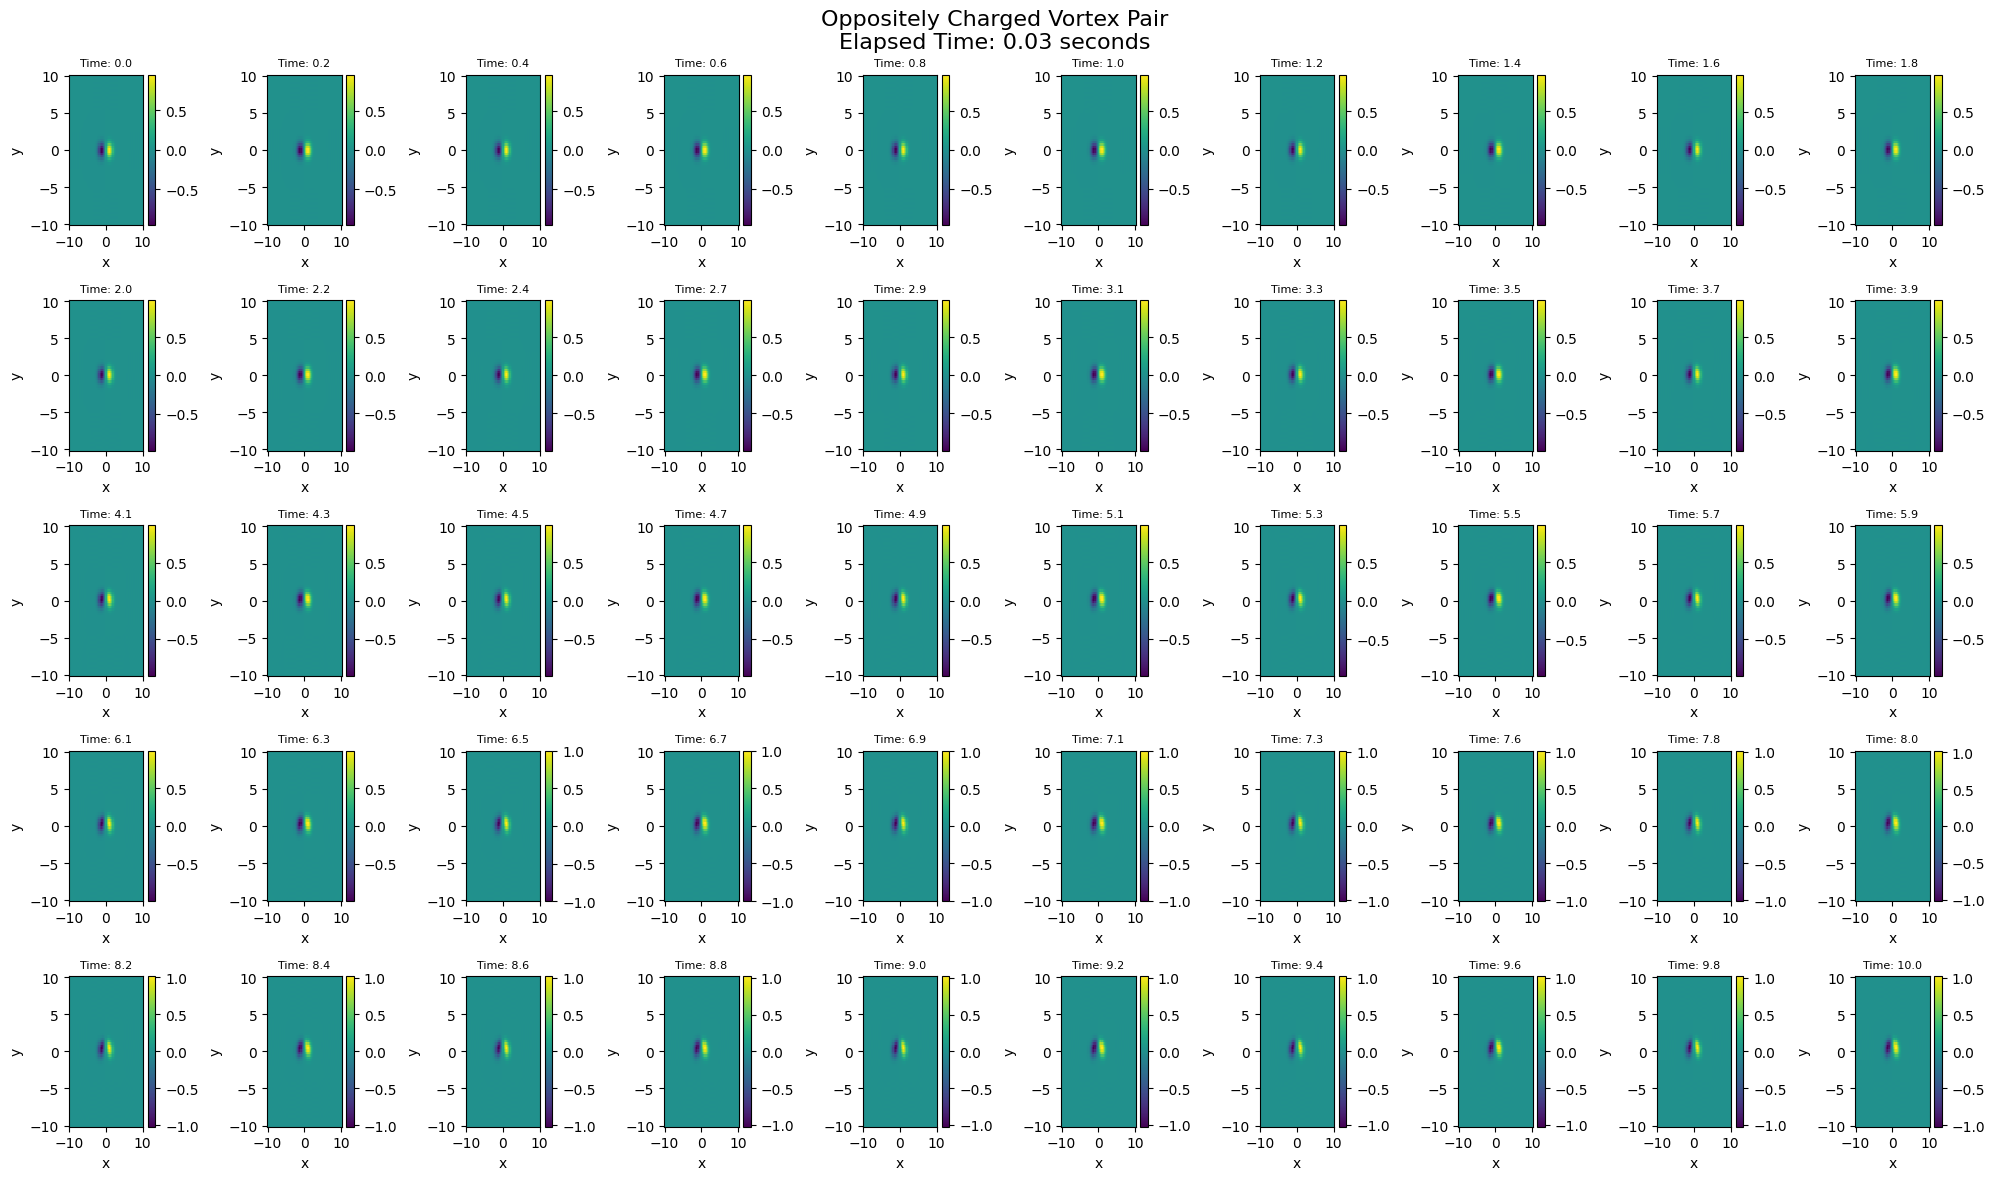

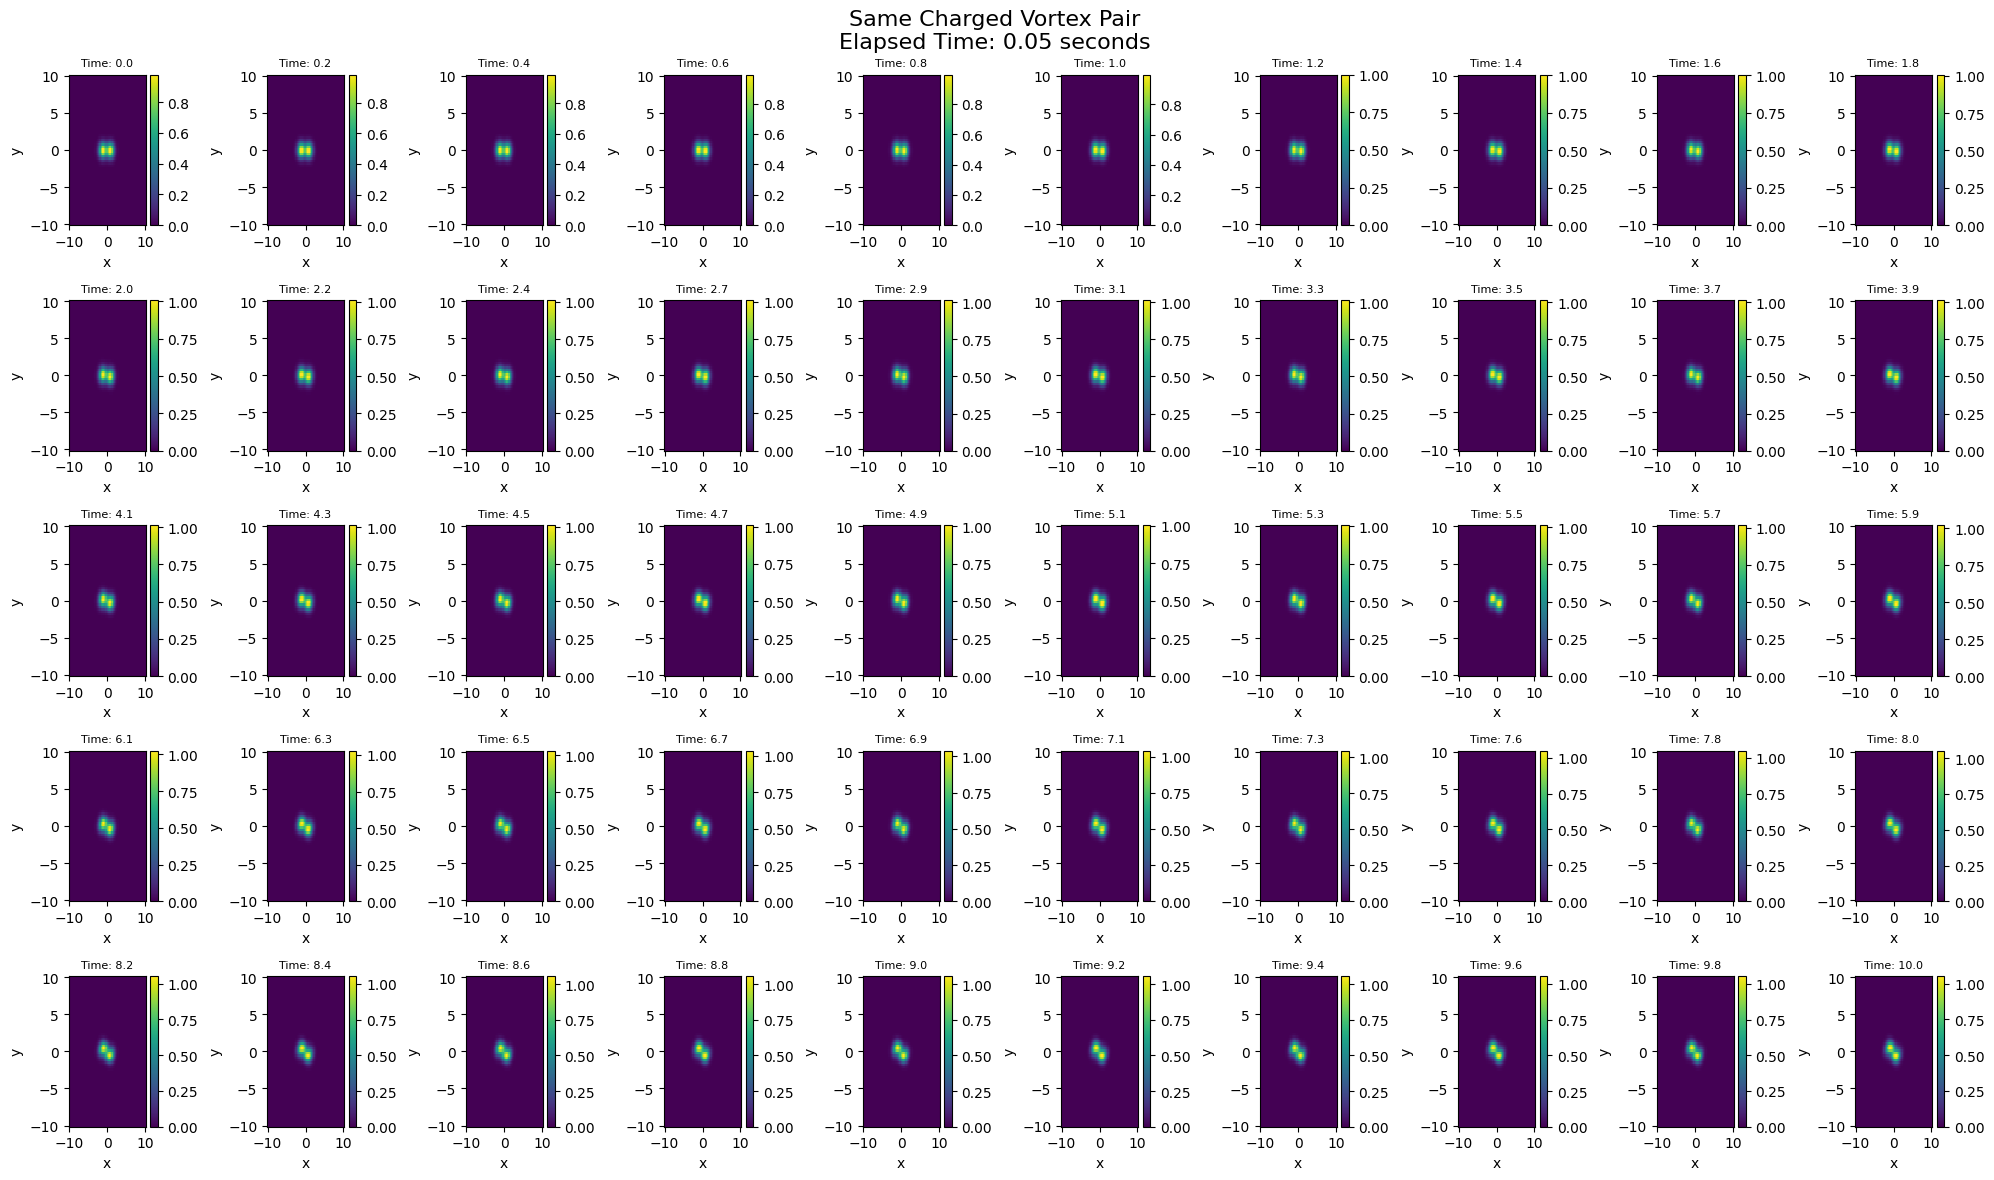

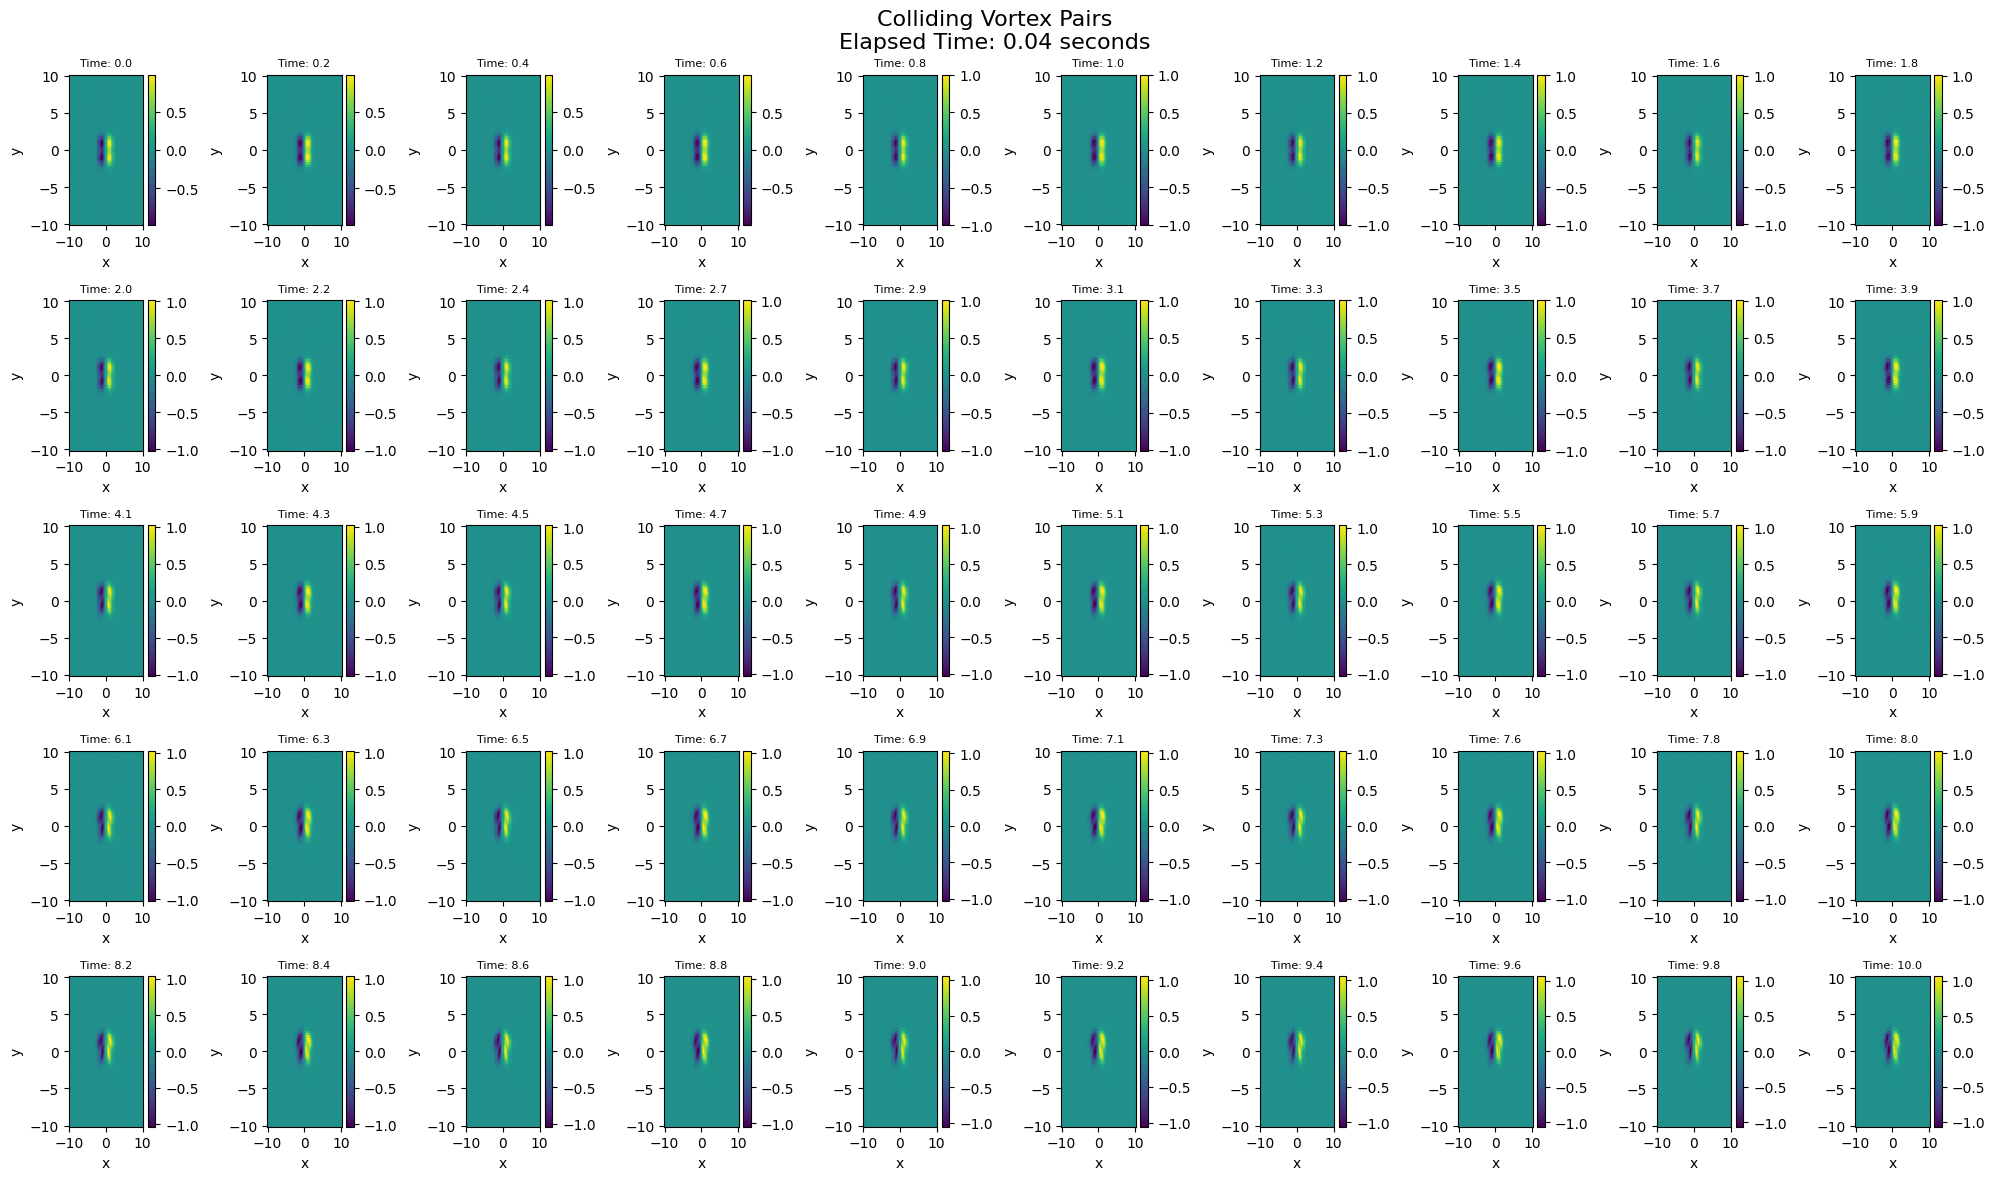

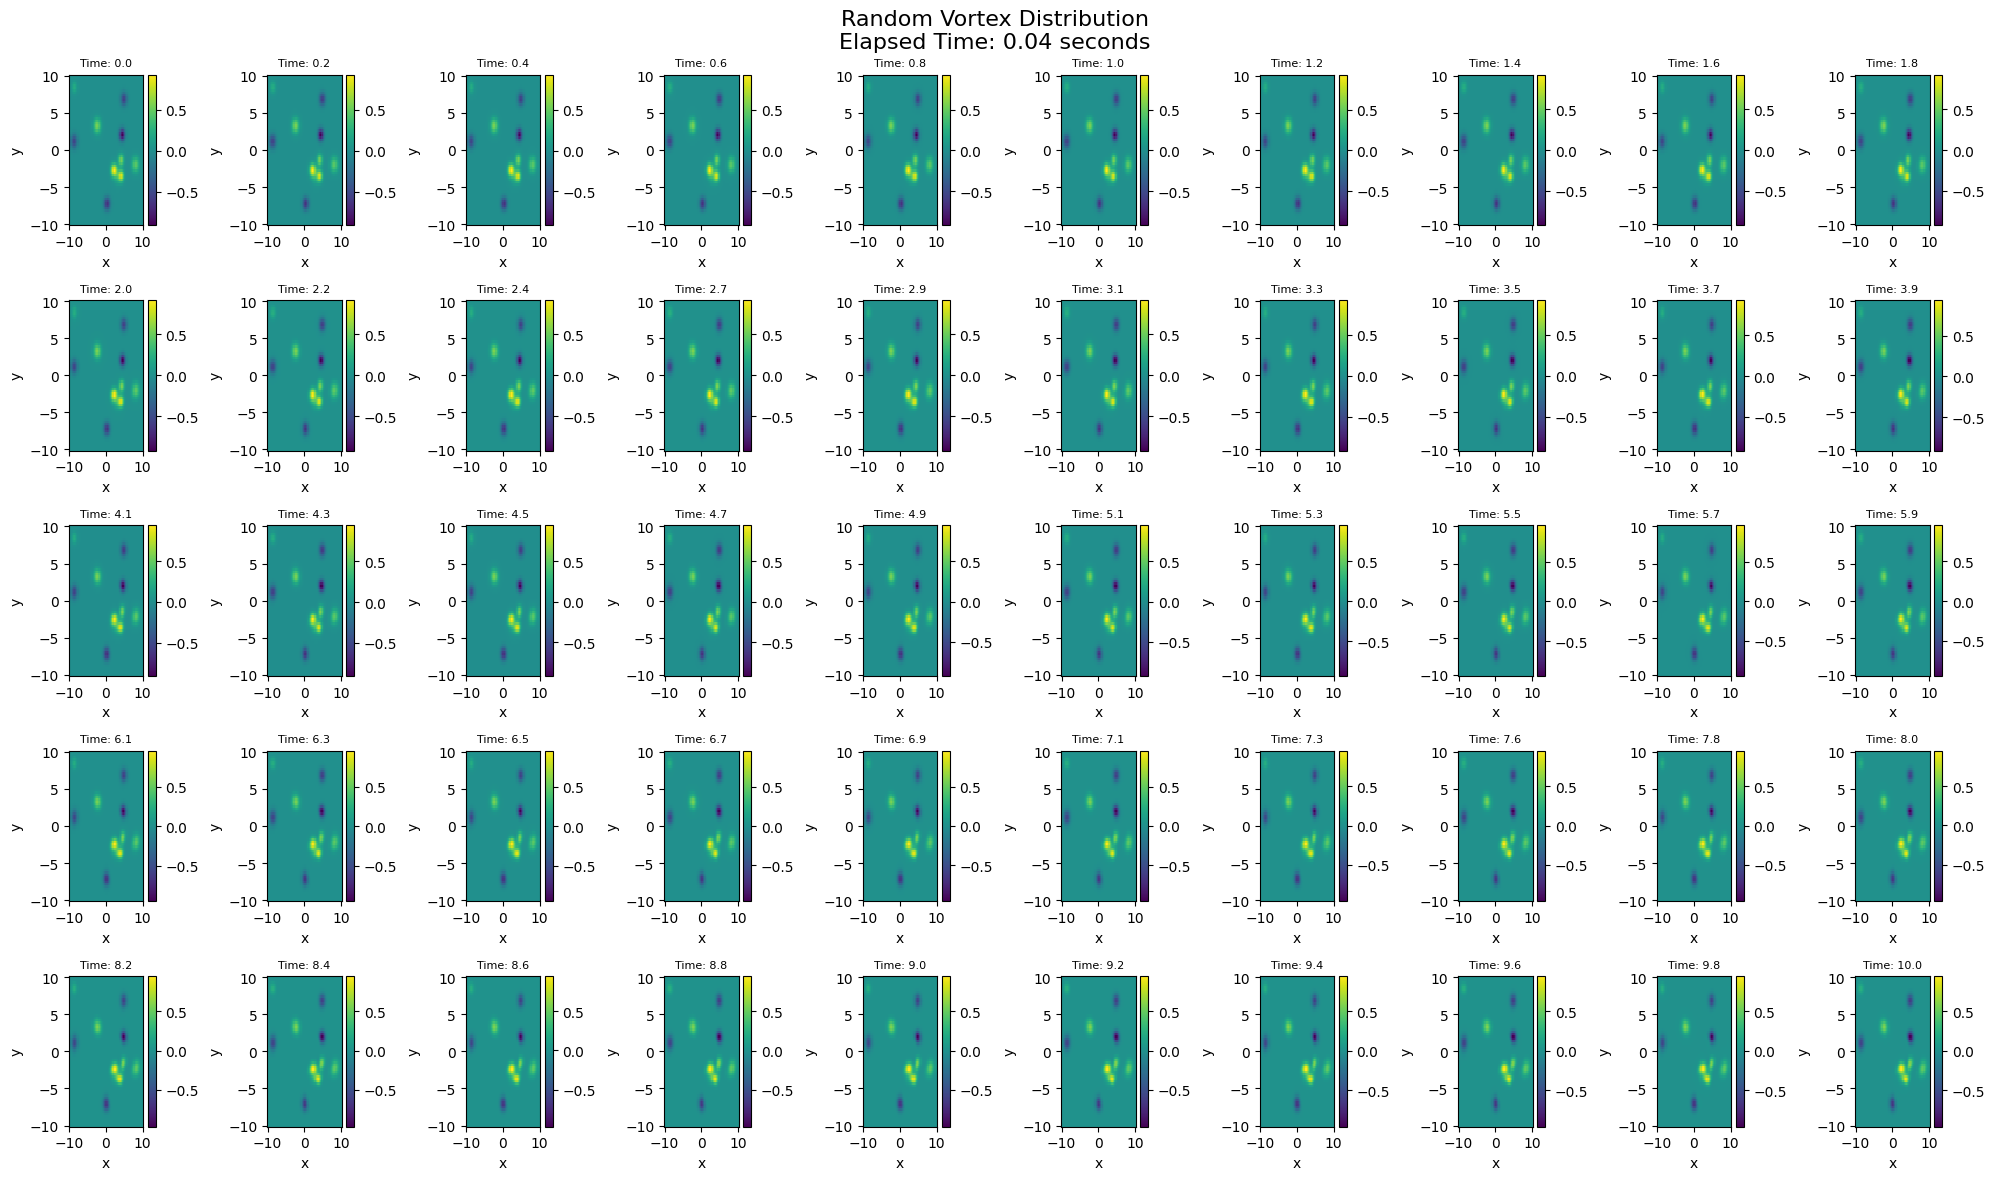

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
import time

Lx, Ly = 20, 20
nx, ny = 64, 64
x = np.linspace(-Lx / 2, Lx / 2, nx)
y = np.linspace(-Ly / 2, Ly / 2, ny)
X, Y = np.meshgrid(x, y)

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx//2), np.arange(-nx//2, 0)))
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny//2), np.arange(-ny//2, 0)))
kx[0], ky[0] = 1e-6, 1e-6  
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2


tspan = np.linspace(0, 10, 50)  
nu = 0.001  


def fft_solver(w, nx, ny, K, nu, dt, steps):
    for _ in range(steps):
        wt = fft2(w)
        psit = -wt / K
        psi = np.real(ifft2(psit))
        
        
        u = np.real(ifft2(1j * KY * psit))  
        v = -np.real(ifft2(1j * KX * psit))  
        nonlinear = u * np.gradient(w, axis=1) + v * np.gradient(w, axis=0)
        
       
        laplace_w = np.real(ifft2(K * wt))
        w = w + dt * (-nonlinear + nu * laplace_w)
    return w


def oppositely_charged_vortices():
    vortex1 = np.exp(-((X - 1)**2 + Y**2))
    vortex2 = -np.exp(-((X + 1)**2 + Y**2))
    return vortex1 + vortex2

def same_charged_vortices():
    vortex1 = np.exp(-((X - 1)**2 + Y**2))
    vortex2 = np.exp(-((X + 1)**2 + Y**2))
    return vortex1 + vortex2

def colliding_vortex_pairs():
    vortex1 = np.exp(-((X - 1)**2 + (Y - 1)**2))
    vortex2 = -np.exp(-((X + 1)**2 + (Y - 1)**2))
    vortex3 = np.exp(-((X - 1)**2 + (Y + 1)**2))
    vortex4 = -np.exp(-((X + 1)**2 + (Y + 1)**2))
    return vortex1 + vortex2 + vortex3 + vortex4

def random_vortices():
    num_vortices = np.random.randint(10, 15)
    w = np.zeros_like(X)
    for _ in range(num_vortices):
        x0 = np.random.uniform(-10, 10)
        y0 = np.random.uniform(-10, 10)
        strength = np.random.uniform(-1, 1)
        sigma = np.random.uniform(0.5, 1.5)
        w += strength * np.exp(-((X - x0)**2 + (Y - y0)**2) / sigma)
    return w


initial_conditions = [
    (oppositely_charged_vortices, "Oppositely Charged Vortex Pair"),
    (same_charged_vortices, "Same Charged Vortex Pair"),
    (colliding_vortex_pairs, "Colliding Vortex Pairs"),
    (random_vortices, "Random Vortex Distribution")
]


for init_func, title in initial_conditions:
    w0 = init_func()  
    w = w0.copy()
    
    
    dt = 0.1  
    steps_per_interval = int((tspan[1] - tspan[0]) / dt)
    
    
    start_time = time.time()
    
    
    w_series = []
    for t in tspan:
        w = fft_solver(w, nx, ny, K, nu, dt, steps_per_interval)
        w_series.append(w)
    
    elapsed_time = time.time() - start_time

    
    plt.figure(figsize=(20, 12))
    plt.suptitle(f'{title}\nElapsed Time: {elapsed_time:.2f} seconds', fontsize=16)
    for i, t in enumerate(tspan):
        plt.subplot(5, 10, i + 1) 
        plt.pcolor(X, Y, w_series[i], shading='auto')
        plt.title(f'Time: {t:.1f}', fontsize=8)
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
    
    plt.tight_layout()
    plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.fftpack import fft2, ifft2
import time

# Domain and grid parameters
Lx, Ly = 20, 20
nx, ny = 64, 64
x = np.linspace(-Lx / 2, Lx / 2, nx)
y = np.linspace(-Ly / 2, Ly / 2, ny)
X, Y = np.meshgrid(x, y)

# Fourier space parameters
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx//2), np.arange(-nx//2, 0)))
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny//2), np.arange(-ny//2, 0)))
kx[0], ky[0] = 1e-6, 1e-6  
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

# Time parameters
tspan = np.linspace(0, 10, 50)
nu = 0.001

# FFT solver for vorticity evolution
def fft_solver(w, nx, ny, K, nu, dt, steps):
    for _ in range(steps):
        wt = fft2(w)
        psit = -wt / K
        psi = np.real(ifft2(psit))
        u = np.real(ifft2(1j * KY * psit))
        v = -np.real(ifft2(1j * KX * psit))
        nonlinear = u * np.gradient(w, axis=1) + v * np.gradient(w, axis=0)
        laplace_w = np.real(ifft2(K * wt))
        w = w + dt * (-nonlinear + nu * laplace_w)
    return w

# Initial conditions
def oppositely_charged_vortices():
    vortex1 = np.exp(-((X - 1)**2 + Y**2))
    vortex2 = -np.exp(-((X + 1)**2 + Y**2))
    return vortex1 + vortex2

def same_charged_vortices():
    vortex1 = np.exp(-((X - 1)**2 + Y**2))
    vortex2 = np.exp(-((X + 1)**2 + Y**2))
    return vortex1 + vortex2

def colliding_vortex_pairs():
    vortex1 = np.exp(-((X - 1)**2 + (Y - 1)**2))
    vortex2 = -np.exp(-((X + 1)**2 + (Y - 1)**2))
    vortex3 = np.exp(-((X - 1)**2 + (Y + 1)**2))
    vortex4 = -np.exp(-((X + 1)**2 + (Y + 1)**2))
    return vortex1 + vortex2 + vortex3 + vortex4

def random_vortices():
    num_vortices = np.random.randint(10, 15)
    w = np.zeros_like(X)
    for _ in range(num_vortices):
        x0 = np.random.uniform(-10, 10)
        y0 = np.random.uniform(-10, 10)
        strength = np.random.uniform(-1, 1)
        sigma = np.random.uniform(0.5, 1.5)
        w += strength * np.exp(-((X - x0)**2 + (Y - y0)**2) / sigma)
    return w

# List of initial conditions
initial_conditions = [
    (oppositely_charged_vortices, "Oppositely Charged Vortex Pair"),
    (same_charged_vortices, "Same Charged Vortex Pair"),
    (colliding_vortex_pairs, "Colliding Vortex Pairs"),
    (random_vortices, "Random Vortex Distribution")
]

# Generate and save animations for each case
for init_func, title in initial_conditions:
    w0 = init_func()  
    w = w0.copy()
    
    dt = 0.1  
    steps_per_interval = int((tspan[1] - tspan[0]) / dt)
    
    # Generate vorticity field over time
    w_series = []
    for t in tspan:
        w = fft_solver(w, nx, ny, K, nu, dt, steps_per_interval)
        w_series.append(w)
    
    # Create animation
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.cm.coolwarm  # Colormap
    contour = ax.pcolor(X, Y, w_series[0], cmap=cmap, shading='auto')
    ax.set_title(f"{title} (Time: {tspan[0]:.2f})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label("Vorticity")
    
    def update(frame):
        contour.set_array(w_series[frame].flatten())  # Update vorticity field
        ax.set_title(f"{title} (Time: {tspan[frame]:.2f})")
        return contour,

    ani = animation.FuncAnimation(
        fig, update, frames=len(w_series), interval=200, blit=False
    )

    # Save animation
    filename = title.lower().replace(" ", "_") + ".mp4"
    ani.save(filename, fps=30, dpi=150, writer="ffmpeg")
    print(f"Animation saved as {filename}")

    plt.close(fig)



Animation saved as oppositely_charged_vortex_pair.mp4
Animation saved as same_charged_vortex_pair.mp4
Animation saved as colliding_vortex_pairs.mp4
Animation saved as random_vortex_distribution.mp4
